In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [2]:
#export
from exp.nb_07a import *

# Data block API
## Load and explore data

In [3]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)
path

PosixPath('/home/fabiograetz/.fastai/data/imagenette-160')

In [4]:
#export
import PIL, os, mimetypes
Path.ls = lambda x: list(x.iterdir())

In [5]:
path.ls()

[PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train')]

In [6]:
(path/"val").ls()

[PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n03888257'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n02979186'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n03425413'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n03028079'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n03445777'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n03000684'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n02102040'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n03394916'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n03417042')]

In [7]:
path_tench = path/"val"/"n01440764"

In [8]:
img_fn = path_tench.ls()[0]

In [9]:
img = PIL.Image.open(img_fn)

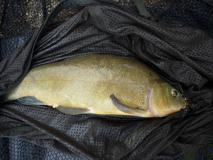

In [10]:
img

In [11]:
import numpy as np

In [12]:
img_arr = np.array(img)

In [13]:
img_arr.shape

(160, 213, 3)

In [14]:
img_arr[:10, :10, 0]

array([[44, 34, 16, 29, ..., 28, 21, 18, 33],
       [45, 33, 26, 48, ..., 22, 22, 15, 37],
       [45, 24, 20, 48, ..., 16, 19, 15, 37],
       [38, 15, 11, 29, ..., 17, 15, 23, 27],
       ...,
       [33, 39, 65, 44, ..., 13, 26, 35, 22],
       [51, 25, 34, 23, ...,  8, 19, 17, 32],
       [47, 15, 24, 40, ..., 14, 20, 32, 26],
       [42, 30, 33, 31, ..., 31, 33, 29, 27]], dtype=uint8)

We just want to keep the images. To filter those, we use `mimetypes`:

In [15]:
#export
image_extensions = set(k for k, v in mimetypes.types_map.items() if v.startswith("image/"))

In [16]:
' '.join(image_extensions)

'.xpm .xwd .ppm .xbm .pbm .pnm .svg .png .ico .gif .ras .jpg .rgb .tiff .jpe .ief .pgm .tif .bmp .jpeg'

In [17]:
#export
def setify(x):
    return x if isinstance(x, set) else set(listify(x))

In [18]:
test_eq(setify(["aa", 1]), {"aa", 1})
test_eq(setify(None), set())
test_eq(setify(1), {1})
test_eq(setify({1}), {1})

We (recursively) walk through all directories and grab all image files:

In [19]:
#export
def _get_files(p, fs, extensions=None):
    p = Path(p)
    res = [p/f for f in fs if not f.startswith('.')
           and ((not extensions) or f'.{f.split(".")[-1].lower()}' in extensions)]
    return res

In [20]:
t = [o.name for o in os.scandir(path_tench)]
t = _get_files(path, t, extensions=image_extensions)
t[:3]

[PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/ILSVRC2012_val_00017472.JPEG'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/ILSVRC2012_val_00009346.JPEG'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/ILSVRC2012_val_00045866.JPEG')]

In [21]:
#export
def get_files(path, extensions=None, recurse=False, include=None):
    path = Path(path)
    extensions = setify(extensions)
    extensions = {e.lower() for e in extensions}
    
    if recurse:
        res = []
        for i,(p,d,f) in enumerate(os.walk(path)): # returns (dirpath, dirnames, filenames)
            if include is not None and i==0: d[:] = [o for o in d if o in include]
            else:                            d[:] = [o for o in d if not o.startswith('.')]
            res += _get_files(p, f, extensions)
        return res
    else:
        f = [o.name for o in os.scandir(path) if o.is_file()]
        return _get_files(path, f, extensions)

Reason we do it so complicated is that `os.scandir` is super fast.

In [22]:
get_files(path_tench, image_extensions)[:3]

[PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00009346.JPEG'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00045866.JPEG')]

We need the recurse argument when we start from path since the pictures are two level below in directories.

In [23]:
get_files(path, image_extensions, recurse=True)[:3]

[PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00009346.JPEG'),
 PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00045866.JPEG')]

In [24]:
all_fns = get_files(path, image_extensions, recurse=True)
len(all_fns)

13394

Imagenet is 100x larger, this has to be fast!

In [25]:
%timeit -n 10 get_files(path, image_extensions, recurse=True)

50.5 ms ± 1.23 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Prepare for modeling
What we need to do:

* Get files
* Split validation set
  * random %
  * folder name
  * csv, ...
* Label:
  * folder name
  * file name/re
  * csv, ...
* Transform per image (optional)
* Transform to tensor
* DataLoader
* Transform per batch (optional)
* DataBunch
* Add test set (optional)

### Get files

* We use `ListContainer` from notebook 06
* Overload `get` method to specify how to access an item, i.e. open an image.
* Private `_get` allows to apply a transform to it
* `new` will be used in conjunction with `__getitem__` (that works for one index or a list of indices) to create training and validation set from a single stream when we split the data.

In [26]:
??ListContainer

In [27]:
#export
def compose(x, funcs, *args, order_key='_order', **kwargs):
    key = lambda o: getattr(o, order_key, 0)
    
    # order the funcs with respect to their order_keys and apply them
    for f in sorted(listify(funcs), key=key): x = f(x, **kwargs)
    return x

In [28]:
#export
class ItemList(ListContainer):
    def __init__(self, items, path=".", tfms=None):
        super().__init__(items)
        self.path, self.tfms = path, tfms
        
    def __repr__(self):
        return f'{super().__repr__()}\n Path: {self.path}'
    
    def new(self, items, cls=None):
        if cls is None: cls = self.__class__
        return cls(items, self.path, tfms=self.tfms)
    
    def get(self, i): return i
    def _get(self, i): return compose(self.get(i), self.tfms)
    
    def __getitem__(self, idx):
        res = super().__getitem__(idx)
        if isinstance(res, list): return [self._get(o) for o in res]
        return self._get(res)
        # we use _get so that the tfms are applied

In [29]:
#export
class ImageList(ItemList):
    @classmethod
    def from_files(cls, path, extensions=None, recurse=True, include=None, **kwargs):
        if extensions is None: extensions = image_extensions
        return cls(get_files(path, extensions, recurse=recurse, include=include), path, **kwargs)
    
    def get(self, fn): return PIL.Image.open(fn)

Transforms can be used not only for data augmentation but i.e. also for converting all loaded images to RGB.

They can be a function or a functor that take an item of `ItemList` and transform it. When they are a class, they can have an `_order` attribute.

In [30]:
#export
class Transform():
    _order = 0
    
class MakeRGB(Transform):
    def __call__(self, item): return item.convert('RGB')
    
def make_rgb(item): return item.convert('RGB')

In [31]:
il = ImageList.from_files(path, tfms=make_rgb)

In [32]:
il

ImageList (13394 items)
 [PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00009346.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00045866.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00046252.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00025527.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00045880.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00003014.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00048204.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00024327.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/image

In [33]:
??ListContainer

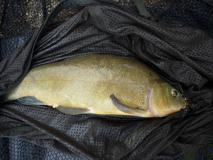

In [34]:
img = il[0]; img

Indexing with a range of integers:

In [35]:
il[:2]

[<PIL.Image.Image image mode=RGB size=213x160 at 0x7F05C28DE9B0>,
 <PIL.Image.Image image mode=RGB size=213x160 at 0x7F05C28DE7B8>]

### Split validation set

In [36]:
fn = il.items[0]; fn  # il[0] would call _get and get and give image

PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/val/n01440764/ILSVRC2012_val_00017472.JPEG')

In [37]:
fn.parent.parent.name

'val'

We split by the grandparent's name.

In [38]:
#export
def grandparent_splitter(fn, valid_name='valid', train_name='train'):
    gp = fn.parent.parent.name
    return True if gp==valid_name else False if gp==train_name else None

In [39]:
#export
def split_by_func(items, f):
    mask = [f(o) for o in items]
    
    f = [o for o, m in zip(items, mask) if m==False]
    t = [o for o, m in zip(items, mask) if m==True ]
    
    return f,t

In [40]:
splitter = partial(grandparent_splitter, valid_name="val")

In [41]:
%time train, valid = split_by_func(il, splitter)

CPU times: user 25.8 ms, sys: 333 µs, total: 26.1 ms
Wall time: 26 ms


In [42]:
type(train)

list

In [43]:
len(train), len(valid)

(12894, 500)

In [44]:
#export
class SplitData():
    def __init__(self, train, valid):
        self.train, self.valid = train, valid
        
    def __getattr__(self, k): return getattr(self.train, k)
    # try to grab unknown attributes from the train ItemList
    
    def __setstate__(self, data:Any): self.__dict__.update(data)
    #This is needed if we want to pickle SplitData and be able to load it back without recursion errors

    @classmethod
    def split_by_func(cls, il, f):
        lists = map(il.new, split_by_func(il.items, f))
        # calling il.new makes sure the lists are of the same type as il (might not be ItemList but inheriting class)
        
        return cls(*lists)  # a SplitData object containing train and val data
    
    def __repr__(self):
        return f'{self.__class__.__name__}\nTrain: {self.train}\nValid: {self.valid}\n'

In [45]:
sd = SplitData.split_by_func(il, splitter)

In [46]:
sd

SplitData
Train: ImageList (12894 items)
 [PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_17927.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_10183.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_10847.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_12111.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_12188.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_5879.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_13643.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_13855.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_14294.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_12

### Labeling

Has to occur after splitting because only train set information is used to create the vocab of classes. We use a `Processor` to do the labeling. The `Processor` computes a state on the train set and uses this on the valid set.

For instance, it could be processing texts to *tokenize*, then *numericalize* them. In that case we want the validation set to be numericalized with exactly the same vocabulary as the training set.

Another example is in tabular data, where we fill missing values with (for instance) the median computed on the training set. That statistic is stored in the inner state of the Processor and applied on the validation set.

Here: convert label strings to number in consistent and reproducible way.

In [47]:
#export
from collections import OrderedDict

def uniqueify(x, sort=False):
    res = list(OrderedDict.fromkeys(x).keys())
    if sort: res.sort()
    return res

In [48]:
#export
class Processor():
    def process(self, items): return items

In [49]:
#export
class CategoryProcessor(Processor):
    def __init__(self): self.vocab = None
        
    def __call__(self, items):
        # Define vocab on first use (train data)
        if self.vocab is None:
            self.vocab = uniqueify(items)
            self.otoi = {v:k for k, v in enumerate(self.vocab)}  # object to idx
        return [self.proc1(o) for o in items]
    
    def proc1(self, item):
        return self.otoi[item]
    
    def deprocess(self, idxs):
        assert self.vocab is not None
        return [self.deproc1(idx) for idx in idxs]
    
    def deproc1(self, idx):
        return self.vocab[idx]

We need to label according to the parent folder name here:

In [50]:
fn.parent.name

'n01440764'

We label the training set first with a newly created `CategoryProcessor` so that it computes its inner vocab on that set. Then we label the validation set using the same processor, which means it uses the same vocab. The end result is another `SplitData` object.

In [51]:
#export
def parent_labeler(fn):
    return fn.parent.name

def _label_by_func(ds, f, cls=ItemList):
    return cls([f(o) for o in ds.items], path=ds.path)

In [52]:
#export
class LabeledData():
    def process(self, il, proc):
        return il.new(compose(il.items, proc))
    
    def __init__(self, x, y, proc_x=None, proc_y=None):
        self.x, self.y = self.process(x, proc_x), self.process(y, proc_y)
        
        self.proc_x, self.proc_y = proc_x, proc_y
        
    def __repr__(self): return f'{self.__class__.__name__}\nx: {self.x}\ny: {self.y}\n'
    
    def __getitem__(self,idx): return self.x[idx],self.y[idx]
    def __len__(self): return len(self.x)
    
    def x_obj(self, idx): return self.obj(self.x, idx, self.proc_x)
    def y_obj(self, idx): return self.obj(self.y, idx, self.proc_y)
            
    def obj(self, items, idx, procs):
        isint = isinstance(idx, int) or (isinstance(idx,torch.LongTensor) and not idx.ndim)
        item = items[idx]
        for proc in reversed(listify(procs)):
            item = proc.deproc1(item) if isint else proc.deprocess(item)
        return item

    @classmethod
    def label_by_func(cls, il, f, proc_x=None, proc_y=None):
        return cls(il, _label_by_func(il, f), proc_x=proc_x, proc_y=proc_y)
    
def label_by_func(sd, f, proc_x=None, proc_y=None):
    # for images proc_x stays None, proc_y is CategoryProcessor

    train = LabeledData.label_by_func(sd.train, f, proc_x=proc_x, proc_y=proc_y)
    valid = LabeledData.label_by_func(sd.valid, f, proc_x=proc_x, proc_y=proc_y)
    return SplitData(train,valid)

In [53]:
sd

SplitData
Train: ImageList (12894 items)
 [PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_17927.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_10183.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_10847.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_12111.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_12188.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_5879.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_13643.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_13855.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_14294.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_12

In [54]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [55]:
assert ll.train.proc_y is ll.valid.proc_y

In [56]:
ll.train.proc_x is None

True

In [57]:
ll.train.y

ItemList (12894 items)
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0...]
 Path: /home/fabiograetz/.fastai/data/imagenette-160

In [58]:
ll.train.y.items[0], ll.train.y_obj(0), ll.train.y_obj(slice(2))

(0, 'n01440764', ['n01440764', 'n01440764'])

In [59]:
ll

SplitData
Train: LabeledData
x: ImageList (12894 items)
 [PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_17927.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_10183.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_10847.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_12111.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_12188.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_5879.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_13643.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_13855.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n01440764/n01440764_14294.JPEG'), PosixPath('/home/fabiograetz/.fastai/data/imagenette-160/train/n014407

### Transform to tensor

In [60]:
ll.train[0]

(<PIL.Image.Image image mode=RGB size=240x160 at 0x7F05C1FD5898>, 0)

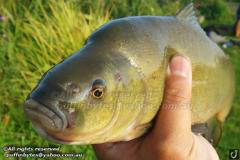

In [61]:
ll.train[0][0]

They have to have the same size so that we can stack them into batches. Then the image has to be converted to a tensor, to float, and divided by 255.

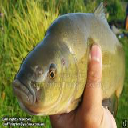

In [62]:
ll.train[0][0].resize((128, 128))

In [63]:
#export
class ResizeFixed(Transform):
    _order = 10
    def __init__(self, size):
        if isinstance(size, int): size = (size, size)
        self.size = size
    
    def __call__(self, item):
        return item.resize(self.size, PIL.Image.BILINEAR)

In [64]:
#export
def to_byte_tensor(item):
    res = torch.ByteTensor(torch.ByteStorage.from_buffer(item.tobytes()))
    
    w, h = item.size
    
    return res.view(h,w, -1).permute(2, 0, 1)

to_byte_tensor._order=20

In [65]:
#export
def to_float_tensor(item):
    return item.float().div_(255.)

to_float_tensor._order=30

In [66]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [67]:
il = ImageList.from_files(path, tfms=tfms)

In [68]:
sd = SplitData.split_by_func(il, splitter)

In [69]:
ll = label_by_func(sd, parent_labeler, proc_y=CategoryProcessor())

In [70]:
type(il), type(sd), type(ll)

(__main__.ImageList, __main__.SplitData, __main__.SplitData)

In [71]:
type(sd.train)

__main__.ImageList

In [72]:
#export
def show_image(im, figsize=(3,3)):
    plt.figure(figsize=figsize)
    plt.axis('off')
    plt.imshow(im.permute(1, 2, 0))

In [73]:
x, y = ll.train[1500]

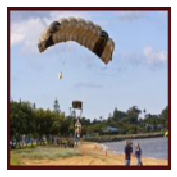

In [74]:
show_image(x)

### DataBunch
Put our datasets into a `DataBunch`

In [75]:
bs = 64

In [76]:
??DataLoader

In [77]:
train_dl, valid_dl = get_dls(ll.train, ll.valid, bs, num_workers=4)

In [78]:
x, y = next(iter(train_dl))

In [79]:
x.shape

torch.Size([64, 3, 128, 128])

'n03445777'

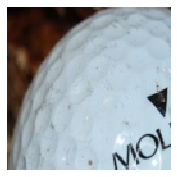

In [80]:
show_image(x[0])
ll.train.proc_y.vocab[y[0]]

In [81]:
y

tensor([5, 7, 6, 1, 4, 4, 9, 1, 9, 2, 5, 2, 7, 0, 8, 7, 2, 3, 7, 1, 8, 7, 6, 8,
        0, 3, 5, 2, 9, 2, 1, 5, 5, 0, 3, 4, 9, 0, 2, 8, 5, 1, 9, 1, 9, 9, 4, 0,
        9, 8, 5, 4, 5, 9, 0, 6, 0, 9, 6, 5, 3, 2, 2, 8])

Adapt the `DataBunch` by replacing `c` with `c_in` and `c_out`:

In [82]:
#export
class DataBunch():
    def __init__(self, train_dl, valid_dl, c_in=None, c_out=None):
        self.train_dl, self.valid_dl, self.c_in, self.c_out = train_dl, valid_dl, c_in, c_out

    @property
    def train_ds(self): return self.train_dl.dataset

    @property
    def valid_ds(self): return self.valid_dl.dataset

Define a function that goes from the `SplitData` object to a `DataBunch`

In [83]:
#export
def databunchify(sd, bs, c_in=None, c_out=None, **kwargs):
    dls = get_dls(sd.train, sd.valid, bs, **kwargs)
    return DataBunch(*dls, c_in=c_in, c_out=c_out)

SplitData.to_databunch = databunchify

Full summary of how to use Data block api to put data into a `DataBunch`

In [84]:
path = datasets.untar_data(datasets.URLs.IMAGENETTE_160)

In [85]:
tfms = [make_rgb, ResizeFixed(128), to_byte_tensor, to_float_tensor]

In [86]:
il = ImageList.from_files(path, tfms=tfms)

In [87]:
type(il)

__main__.ImageList

In [88]:
sd = SplitData.split_by_func(il, partial(grandparent_splitter, valid_name="val"))

In [89]:
type(sd.train)

__main__.ImageList

In [90]:
ll = label_by_func(sd, parent_labeler, proc_y = CategoryProcessor())

In [91]:
type(ll)

__main__.SplitData

In [92]:
type(ll.train), type(ll.train.x), type(ll.train.y)

(__main__.LabeledData, __main__.ImageList, __main__.ItemList)

In [93]:
ll.train.proc_x is None, ll.train.proc_y

(True, <__main__.CategoryProcessor at 0x7f05c42935f8>)

In [94]:
data = ll.to_databunch(bs, c_in=3, c_out=10, num_workers=4)

In [95]:
type(data.train_ds)  # instead of PyTorch Dataset

__main__.LabeledData

### Model

In [96]:
cbfs = [Recorder, partial(AvgStatsCallback, accuracy),
       CudaCallback]

For simplicity we will use the statistics from a batch to normalize all inputs:

In [97]:
m, s = x.mean((0, 2, 3)).cuda(), x.std((0, 2, 3)).cuda()

In [98]:
m, s

(tensor([0.4589, 0.4347, 0.3932], device='cuda:0'),
 tensor([0.2703, 0.2610, 0.2810], device='cuda:0'))

In [99]:
x.shape, m.shape

(torch.Size([64, 3, 128, 128]), torch.Size([3]))

In [100]:
#export
def normalize_chan(x, mean, std):
    return (x-mean[..., None, None])/std[..., None, None]

_m = tensor([0.47, 0.48, 0.45])
_s = tensor([0.29, 0.28, 0.30])

norm_imagenette = partial(normalize_chan, mean=_m.cuda(), std=_s.cuda())

In [101]:
(m[..., None, None]).shape

torch.Size([3, 1, 1])

In [102]:
cbfs.append(partial(BatchTransformXCallback, norm_imagenette))

In [103]:
nfs = [64, 64, 128, 256]

In [104]:
#export
import math

def prev_pow_2(x): return 2**math.floor(math.log2(x))

def get_cnn_layers(data, nfs, layer, **kwargs):
    def f(ni, nf, stride=2): return layer(ni, nf, 3, stride=stride, **kwargs)
    l1 = data.c_in
    l2 = prev_pow_2(l1*3*3)
    layers =  [f(l1  , l2  , stride=1),
               f(l2  , l2*2, stride=2),
               f(l2*2, l2*4, stride=2)]
    nfs = [l2*4] + nfs
    layers += [f(nfs[i], nfs[i+1]) for i in range(len(nfs)-1)]
    layers += [nn.AdaptiveAvgPool2d(1), Lambda(flatten), 
               nn.Linear(nfs[-1], data.c_out)]
    return layers

In [105]:
#export
def get_cnn_model(data, nfs, layer, **kwargs):
    return nn.Sequential(*get_cnn_layers(data, nfs, layer, **kwargs))

In [106]:
#export
def get_learn_run(nfs, data, lr, layer, cbs=None, opt_func=None, **kwargs):
    model = get_cnn_model(data, nfs, layer, **kwargs)
    init_cnn(model)
    return get_runner(model, data, lr=lr, cbs=cbs, opt_func=opt_func)

In [107]:
sched = combine_scheds([0.3, 0.7], [sched_cos(0.1, 0.3), sched_cos(0.3, 0.05)])

In [108]:
??init_cnn_

In [109]:
learn,run = get_learn_run(nfs, data, 0.2, conv_layer, cbs=cbfs+[
    partial(ParamScheduler, 'lr', sched)
])

Let's write a convenience function to look at the shapes of the feature maps of our network using Hooks:

In [119]:
#export
def model_summary(run, learn, data, find_all=False):
    xb, yb = next(iter(data.train_dl))
    device = next(learn.model.parameters()).device  # Model may not be on gpu yet
    xb, yb = xb.to(device), yb.to(device)
    mods = find_modules(learn.model, is_lin_layer) if find_all else learn.model.children()

    f = lambda hook, mod, inp, out: print(f"{mod}\n{out.shape}\n")
    
    with Hooks(mods, f) as hooks: 
        learn.model(xb)

In [120]:
model_summary(run, learn, data)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 16, 128, 128])

Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 32, 64, 64])

Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 64, 32, 32])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
  (1): GeneralRelu()
  (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
torch.Size([64, 64, 16, 16])

Sequential(
  (0): Conv2d(64, 64, kernel_size=(3, 3

In [122]:
%time run.fit(5, learn)

train: [1.7697305917480999, tensor(0.3874, device='cuda:0')]
valid: [1.8667188720703125, tensor(0.4340, device='cuda:0')]
train: [1.3573838546513883, tensor(0.5465, device='cuda:0')]
valid: [1.2514732666015624, tensor(0.5900, device='cuda:0')]
train: [1.0376336316794632, tensor(0.6578, device='cuda:0')]
valid: [1.0873997802734374, tensor(0.6420, device='cuda:0')]
train: [0.7529686167015667, tensor(0.7558, device='cuda:0')]
valid: [0.8672628173828125, tensor(0.7340, device='cuda:0')]
train: [0.5325511366115053, tensor(0.8352, device='cuda:0')]
valid: [0.8592376098632812, tensor(0.7440, device='cuda:0')]
CPU times: user 15.7 s, sys: 4.99 s, total: 20.6 s
Wall time: 22.9 s


## Export

In [123]:
!python notebook2script.py 08_data_block.ipynb

Converted 08_data_block.ipynb to exp/nb_08.py
